## Import Libraries

In [0]:
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from keras.losses import categorical_crossentropy
import keras.layers as l
import keras
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
drive.mount('/gdrive')

Using TensorFlow backend.


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Load Images

In [0]:
data = [np.load('/gdrive/My Drive/CS 168/DSA Colab Notebook/means/fractals_' + str(i) + '.npy', allow_pickle=True).item() for i in range(1, 202)]

we could probably try throwing these images out
1, 2, 101

we could modify the following images (where they are averaged), because the mean doesn't look as good as the original 
10, 13, 37, 74, 75, 88, 93, 96, 108

In [0]:
# get the labels by determining which is the best label to use (dr1, dr2, or report)
def get_y(x):
    yr = x['TICI_report'][0]
    yd1 = x['TICI_Dr1'][0]
    yd2 = x['TICI_Dr2'][0]
    if (isinstance(yr, np.ndarray)):
        yr = yr[0]
    if (isinstance(yd1, np.ndarray)):
        yd1 = yd1[0]
    if(isinstance(yd2, np.ndarray)):
        yd2 = yd2[0]
        
    if (isinstance(yd1, str)) or (isinstance(yd1, np.uint8)):
      return yd1
    elif (isinstance(yd2, str)) or (isinstance(yd2, np.uint8)):
      return yd2
    elif (isinstance(yr, str)) or (isinstance(yr, np.uint8)):
      return yr
    else:
      return None

In [0]:
def get_clean_data (data):
  df = pd.DataFrame(data)
  df = df.drop(['__globals__', '__header__', '__version__'], axis=1)
  df['y'] = 0 # New column in which I'll fill values
  df['y'] = df.apply(lambda x: get_y(x), axis=1)
  data = df[['X', 'y']]
  clean_data = data.dropna(how='any')
  clean_data.loc[clean_data['y'] == '0 (bilateral MCA)', ['y']]= 0

  # For this datapoint, I thought '2a?' might be another type of category, but
  # I believe there is only one data point that has '2a?' as a category so I'm
  # going to treat it as an error and convert it to '2a'
  clean_data.loc[clean_data['y'] == '2a?', ['y']] = '2a'
  return clean_data

In [0]:
clean_data = get_clean_data(data)
del data

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


## Train-Test-split and to_categorical

In [0]:
TEST_SIZE = 0.2
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(clean_data.drop('y', axis=1), clean_data['y'], test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=False, stratify=None)
del clean_data

In [0]:
# to_categorical (I used pd.get_dummies because they work with dataframes and return column name)
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [0]:
# Converting Pandas DataFrames into numpy arrays, which keras supports
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [0]:
X_train = np.array([arr[0] for arr in X_train])
X_test = np.array([arr[0] for arr in X_test])

## Run CNN

In [0]:
def create_simple_model():
  model = Sequential([
      l.Conv2D(32, 5, padding='same', activation='relu', input_shape=(512,512,1)),
      l.MaxPooling2D((2, 2), (2, 2), padding='same'),
      l.BatchNormalization(),
      l.Conv2D(64, 5, padding='same', activation='relu'),
      l.MaxPooling2D((2, 2), (2, 2), padding='same'),
      l.Conv2D(64, 5, padding='same', activation='relu'),
      l.MaxPooling2D((2, 2), (2, 2), padding='same'),
      l.Conv2D(64, 5, padding='same', activation='relu'),
      l.MaxPooling2D((2, 2), (2, 2), padding='same'),
      l.Conv2D(64, 5, padding='same', activation='relu'),
      l.MaxPooling2D((2, 2), (2, 2), padding='same'),
      l.Conv2D(64, 5, padding='same', activation='relu'),
      l.MaxPooling2D((2, 2), (2, 2), padding='same'),
      l.Flatten(),
      l.Dense(1024, activation='relu'),
      l.Dropout(0.4),
      l.Dense(5,activation='softmax')
  ])


  model.summary()
  return model

In [0]:
img_rows,img_cols=512,512
def train_simple_model (model, batch_size, epochs, x, y, xt, yt):
  x = x.reshape(x.shape[0], img_rows, img_cols, 1)
  xt = xt.reshape(xt.shape[0], img_rows, img_cols, 1)
  model.compile(
    loss=categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])

  model.fit(x, y,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(xt, yt))
  score = model.evaluate(xt, yt, verbose=0)
  return score

In [0]:
model = create_simple_model()
loss, accuracy = train_simple_model(model, 20, 10, X_train, y_train, X_test, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 512, 512, 32)      832       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 256, 256, 64)      51264     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 64)      102464    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 64)        0         
__________

In [0]:
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.3504295316902366
Test accuracy: 0.37837838160025106


## Run Inception

In [0]:
def create_inception_model():
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape = (512,512,3)) 

  # DNN portion
  # average pooling layer
  x = l.GlobalAveragePooling2D()(base_model.output)
  # fully-connected layer
  x = l.Dense(1024, activation='relu')(x)
  # logistic layer
  output = l.Dense(5, activation='softmax')(x) # 5 is the number of classes in the data, since TICI is 0,1,2a,2b,3

  model_inception = Model(inputs=base_model.input, outputs=output)

  #model_inception.summary()
  
  return model_inception


In [0]:
def train_inception_model(model, batch_size, epochs, x, y, xt, yt):
  # force images to have three channels
  xnew = np.zeros((x.shape[0], 512, 512, 3))
  for i in range(0, x.shape[0]):
      xnew[i, :, :, 0] = x[i]
      xnew[i, :, :, 1] = x[i]
      xnew[i, :, :, 2] = x[i]

  xtnew = np.zeros((xt.shape[0], 512, 512, 3))
  for i in range(0, X_test.shape[0]):
      xtnew[i, :, :, 0] = xt[i]
      xtnew[i, :, :, 1] = xt[i]
      xtnew[i, :, :, 2] = xt[i]
  
  # train model
  rmsprop = keras.optimizers.RMSprop(lr=0.005)
  
  model.compile(optimizer=rmsprop,
                loss=categorical_crossentropy,
                metrics=['accuracy'])

  model.fit(xnew, y,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(xtnew, yt))
  # evaluate model score is accuracy and loss
  score = model.evaluate(xtnew, yt, verbose=0)
  return score

In [0]:
model = create_inception_model()
loss, accuracy = train_inception_model (model, 20, 10, X_train, y_train, X_test, y_test)

87916544/87910968 [==============================] - 3s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 255, 255, 32) 96          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 255, 255, 32) 0           batch_normalization_4[0][0]      
____________________________________________

In [0]:
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 10.019356173437995
Test accuracy: 0.37837837998931473


Whether we use inception or not, we get 37.8% accuracy.... But the test loss is much higher with inception

## Try Bigger Batch Size

### Regular 2D CNN

50 Batch_Size

In [0]:
model = create_simple_model()
loss, accuracy = train_simple_model(model, 50, 10, X_train, y_train, X_test, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_119 (Conv2D)          (None, 512, 512, 32)      832       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_99 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 256, 256, 64)      51264     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 128, 128, 64)      102464    
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 64, 64, 64)        0         
__________

In [0]:
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.4601407147742607
Test accuracy: 0.37837838160025106


100 Batch_size

In [0]:
model = create_simple_model()
loss, accuracy = train_simple_model(model, 100, 10, X_train, y_train, X_test, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_125 (Conv2D)          (None, 512, 512, 32)      832       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_100 (Bat (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 256, 256, 64)      51264     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 128, 128, 64)      102464    
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 64, 64, 64)        0         
__________

In [0]:
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.3511938339955099
Test accuracy: 0.3243243251297925


This is really not getting higher than 37.8%. 

## Try Adding Some Data Augmentation to the Mix

In [0]:
# augment the images with rotation, width shifts, and height shifts
# only augment the train data
def create_generators(x_train, y_train, x_test, y_test, batch_size, rot, width, height):
    train_d_gen = ImageDataGenerator(
        rotation_range=rot,
        width_shift_range=width,
        height_shift_range=height,
        horizontal_flip=True)
    
    train_d_gen.fit(x_train)
    
    train_gen = train_d_gen.flow(x_train, y_train, batch_size)
    
    validation_gen = ImageDataGenerator().flow(x_test, y_test, batch_size)
    
    return train_gen, validation_gen

In [0]:
img_rows,img_cols=512,512
def train_simple_gen_model (model, batch_size, epochs, x, y, xt, yt, rot=20, width=0.2, height=0.2):
  # add a channel
  x = x.reshape(x.shape[0], img_rows, img_cols, 1)
  xt = xt.reshape(xt.shape[0], img_rows, img_cols, 1)
  # augment
  train_generator, validation_generator = create_generators(x, y, xt, yt, batch_size, rot, width, height)
 
  # train
  model.compile(
    loss=categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])

  model.fit_generator(
        train_generator,
        epochs=10,
        verbose=1,
        steps_per_epoch = np.ceil(x.shape[0]/batch_size),
        validation_steps = np.ceil(xt.shape[0]/batch_size),
        validation_data=validation_generator)
  # evaluate
  score = model.evaluate(xt, yt, verbose=0)
  return score

In [0]:
def train_inception_gen_model(model, batch_size, epochs, x, y, xt, yt, rot=20, width=0.2, height=0.2):
  # force images to have three channels
  xnew = np.zeros((x.shape[0], 512, 512, 3))
  for i in range(0, x.shape[0]):
      xnew[i, :, :, 0] = x[i]
      xnew[i, :, :, 1] = x[i]
      xnew[i, :, :, 2] = x[i]

  xtnew = np.zeros((xt.shape[0], 512, 512, 3))
  for i in range(0, xt.shape[0]):
      xtnew[i, :, :, 0] = xt[i]
      xtnew[i, :, :, 1] = xt[i]
      xtnew[i, :, :, 2] = xt[i]
 
  # augment
  train_generator, validation_generator = create_generators(xnew, y, xtnew, yt, batch_size, rot, width, height)

  rmsprop = keras.optimizers.RMSprop(lr=0.005)
  
  #train
  model.compile(
    loss=categorical_crossentropy,
    optimizer=rmsprop,
    metrics=['accuracy'])

  model.fit_generator(
        train_generator,
        epochs=epochs,
        verbose=1,
        steps_per_epoch = np.ceil(x.shape[0]/batch_size),
        validation_steps = np.ceil(xt.shape[0]/batch_size),
        validation_data=validation_generator)
  # evaluate
  score = model.evaluate(xtnew, yt, verbose=0)
  return score

### Simple 2D Conv

In [0]:
model = create_simple_model()
loss, accuracy = train_simple_gen_model(model, 20, 10, X_train, y_train, X_test, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_219 (Conv2D)          (None, 512, 512, 32)      832       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_194 (Bat (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_220 (Conv2D)          (None, 256, 256, 64)      51264     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 128, 128, 64)      102464    
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 64, 64, 64)        0         
__________

In [0]:
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Test Loss: 1.3501889866751593
Test Accuracy: 0.37837838160025106


### Inception Conv

In [0]:
model = create_inception_model()
loss, accuracy = train_inception_gen_model(model, 20, 10, X_train, y_train, X_test, y_test)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_343 (Conv2D)             (None, 255, 255, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_293 (BatchN (None, 255, 255, 32) 96          conv2d_343[0][0]                 
__________________________________________________________________________________________________
activation_283 (Activation)     (None, 255, 255, 32) 0           batch_normalization_293[0][0]    
__________________________________________________________________________________________________
conv2d_344

In [0]:
print('Test loss:', loss)
print('Test accuracy:', accuracy) 

Test loss: 10.01935677915006
Test accuracy: 0.37837838160025106


Same accuracy again

## Try Modulating Batch Size and fit_generator parameters

#### Simple Model

37 batch size

In [0]:
model = create_simple_model()
loss, accuracy = train_simple_gen_model(model, 37, 10, X_train, y_train, X_test, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_149 (Conv2D)          (None, 512, 512, 32)      832       
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_104 (Bat (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 256, 256, 64)      51264     
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 128, 128, 64)      102464    
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 64, 64, 64)        0         
__________

In [0]:
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Test Loss: 1.373185157775879
Test Accuracy: 0.37837838160025106


50 batch size

In [0]:
model = create_simple_model()
loss, accuracy = train_simple_gen_model(model, 50, 10, X_train, y_train, X_test, y_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 512, 512, 32)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)    

In [0]:
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.3605993261208404
Test accuracy: 0.37837838160025106


15 epochs

In [0]:
model = create_simple_model()
loss, accuracy = train_simple_gen_model(model, 50, 15, X_train, y_train, X_test, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 512, 512, 32)      832       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 256, 256, 64)      51264     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 64)      102464    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 64)        0         
__________

In [0]:
print('Test loss:', loss)
print('Test accuracy:', accuracy) 

Test loss: 1.3719598538166768
Test accuracy: 0.37837838160025106


#### Inception Model

10 batch size

In [0]:
model = create_inception_model()
loss, accuracy = train_inception_gen_model(model, 10, 10, X_train, y_train, X_test, y_test)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_455 (Conv2D)             (None, 255, 255, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_390 (BatchN (None, 255, 255, 32) 96          conv2d_455[0][0]                 
__________________________________________________________________________________________________
activation_377 (Activation)     (None, 255, 255, 32) 0           batch_normalization_390[0][0]    
__________________________________________________________________________________________________
conv2d_456

In [0]:
print('Test loss:', loss)
print('Test accuracy:', accuracy) 

Test loss: 10.01935677915006
Test accuracy: 0.37837838160025106


Same accuracy, but higher loss than with a larger batch size.

30 batch size

In [0]:
model = create_inception_model()
loss, accuracy = train_inception_gen_model(model, 30, 10, X_train, y_train, X_test, y_test)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_643 (Conv2D)             (None, 255, 255, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_578 (BatchN (None, 255, 255, 32) 96          conv2d_643[0][0]                 
__________________________________________________________________________________________________
activation_565 (Activation)     (None, 255, 255, 32) 0           batch_normalization_578[0][0]    
__________________________________________________________________________________________________
conv2d_644

In [0]:
print('Test loss:', loss)
print('Test accuracy:', accuracy) 

Test loss: 1.7152826705494442
Test accuracy: 0.35135135457322403


Much lower test loss than Inception has ever had, but not super high test accuracy.

30 batch and 15 epochs

In [0]:
model = create_inception_model()
loss, accuracy = train_inception_gen_model(model, 30, 15, X_train, y_train, X_test, y_test)

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 255, 255, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 255, 255, 32) 0           batch_normalization_1[0][0]      
_____________________________________

In [0]:
print("loss", loss)
print('accuracy', accuracy)

loss 10.890604611989614
accuracy 0.3243243251297925


### Try Changing the Ranges in the Creation of Generators

#### Simple Model

In [0]:
model = create_simple_model()
loss, accuracy = train_simple_gen_model(model, 37, 10, X_train, y_train, X_test, y_test, 90, 0.5, 0.5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 512, 512, 32)      832       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 256, 256, 64)      51264     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 64)      102464    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 64)        0         
__________

In [0]:
print('Test loss:', loss)
print('Test accuracy:', accuracy) 

Test loss: 1.352188397098232
Test accuracy: 0.37837838160025106


In [0]:
model = create_simple_model()
loss, accuracy = train_simple_gen_model(model, 20, 10, X_train, y_train, X_test, y_test, 90, 0.5, 0.5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_213 (Conv2D)          (None, 512, 512, 32)      832       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_193 (Bat (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_214 (Conv2D)          (None, 256, 256, 64)      51264     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_215 (Conv2D)          (None, 128, 128, 64)      102464    
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 64, 64, 64)        0         
__________

In [0]:
print('Test loss:', loss)
print('Test accuracy:', accuracy) 

Test loss: 1.3542336096634735
Test accuracy: 0.37837838160025106


#### Inception Model

In [0]:
model = create_inception_model()
loss, accuracy = train_inception_gen_model(model, 20, 10, X_train, y_train, X_test, y_test, 90, 0.5, 0.5)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 255, 255, 32) 96          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 255, 255, 32) 0           batch_normalization_4[0][0]      
__________________________________________________________________________________________________
conv2d_20 

In [0]:
print('Test loss:', loss)
print('Test accuracy:', accuracy) 

Test loss: 9.673247234241382
Test accuracy: 0.37837838160025106


In [0]:
model = create_inception_model()
loss, accuracy = train_inception_gen_model(model, 30, 10, X_train, y_train, X_test, y_test, 90, 0.5, 0.5)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_113 (Conv2D)             (None, 255, 255, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_98 (BatchNo (None, 255, 255, 32) 96          conv2d_113[0][0]                 
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 255, 255, 32) 0           batch_normalization_98[0][0]     
__________________________________________________________________________________________________
conv2d_114

In [0]:
print('Test loss:', loss)
print('Test accuracy:', accuracy) 

Test loss: 9.629059224515348
Test accuracy: 0.37837838160025106


## K-Fold Crossvalidation

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(5)

model = create_simple_model()

x = clean_data.drop('y', axis=1)
y = [str(val) for val in clean_data['y'].values]
x = x.values
x = np.array([arr[0] for arr in x])
acc = 0
j = 1
for train, test in cv.split(x, y):
    x_train = x[train]
    y_train = [y[i] for i in train]
    x_test = x[test]
    y_test = [y[i] for i in test]
    
    y_train = pd.get_dummies(y_train)
    y_test = pd.get_dummies(y_test)
    
    loss, accuracy = train_simple_gen_model(model, 20, 10, x_train, y_train, x_test, y_test)
    print ('Fold #', j, 'Accuracy', accuracy)
    acc+=accuracy
    j+=1
print(acc/(j-1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_315 (Conv2D)          (None, 512, 512, 32)      832       
_________________________________________________________________
max_pooling2d_135 (MaxPoolin (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_210 (Bat (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_316 (Conv2D)          (None, 256, 256, 64)      51264     
_________________________________________________________________
max_pooling2d_136 (MaxPoolin (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_317 (Conv2D)          (None, 128, 128, 64)      102464    
_________________________________________________________________
max_pooling2d_137 (MaxPoolin (None, 64, 64, 64)        0         
__________

Mean accuracy of this model is 45.36%

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(5)

model = create_simple_model()

x = clean_data.drop('y', axis=1)
y = [str(val) for val in clean_data['y'].values]
x = x.values
x = np.array([arr[0] for arr in x])
acc = 0
j = 1
for train, test in cv.split(x, y):
    x_train = x[train]
    y_train = [y[i] for i in train]
    x_test = x[test]
    y_test = [y[i] for i in test]
    
    y_train = pd.get_dummies(y_train)
    y_test = pd.get_dummies(y_test)
    
    loss, accuracy = train_simple_model(model, 20, 10, x_train, y_train, x_test, y_test)
    print ('Fold #', j, 'Accuracy', accuracy)
    acc += accuracy
    j += 1
    
print(acc/(j-1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 512, 512, 32)      832       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 256, 256, 64)      51264     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 64)      102464    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 64)        0         
__________

In [0]:
model = create_simple_model()
acc = 0
j = 1
for train, test in cv.split(x, y):
    x_train = x[train]
    y_train = [y[i] for i in train]
    x_test = x[test]
    y_test = [y[i] for i in test]
    
    y_train = pd.get_dummies(y_train)
    y_test = pd.get_dummies(y_test)
    
    loss, accuracy = train_simple_gen_model(model, 37, 10, x_train, y_train, x_test, y_test, 90, 0.5, 0.5)
    print ('Fold #', j, 'Accuracy', accuracy)
    acc += accuracy
    j += 1
    
print(acc/(j-1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_321 (Conv2D)          (None, 512, 512, 32)      832       
_________________________________________________________________
max_pooling2d_141 (MaxPoolin (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_211 (Bat (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_322 (Conv2D)          (None, 256, 256, 64)      51264     
_________________________________________________________________
max_pooling2d_142 (MaxPoolin (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_323 (Conv2D)          (None, 128, 128, 64)      102464    
_________________________________________________________________
max_pooling2d_143 (MaxPoolin (None, 64, 64, 64)        0         
__________

Mean accuracy of 45.36%

## Confusion Matrix of Best Models (one simple, one inception)

In [0]:
# from the sklearn library example
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
from matplotlib import pyplot as plt
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

#### Simple

In [0]:
img_rows,img_cols=512,512
def train_simple_gen_model (model, batch_size, epochs, x, y, xt, yt, rot=20, width=0.2, height=0.2):
  x = x.reshape(x.shape[0], img_rows, img_cols, 1)
  xt = xt.reshape(xt.shape[0], img_rows, img_cols, 1)
  train_generator, validation_generator = create_generators(x, y, xt, yt, batch_size, rot, width, height)
  
  model.compile(
    loss=categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])

  model.fit_generator(
        train_generator,
        epochs=10,
        verbose=1,
        steps_per_epoch = np.ceil(x.shape[0]/batch_size),
        validation_steps = np.ceil(xt.shape[0]/batch_size),
        validation_data=validation_generator)
  score = model.evaluate(xt, yt, verbose=0)
  return score, model

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

cv = StratifiedKFold(5)

model = create_simple_model()

x = clean_data.drop('y', axis=1)
y = [str(val) for val in clean_data['y'].values]
x = x.values
x = np.array([arr[0] for arr in x])

acc = 0
preds = np.array([])
ys = np.array([])
target_names = ['0', '1', '2a', '2b', '3']

j = 1
for train, test in cv.split(x, y):
    x_train = x[train]
    y_train = [y[i] for i in train]
    x_test = x[test]
    y_test = [y[i] for i in test]
    
    y_train_hot = pd.get_dummies(y_train)
    y_test_hot = pd.get_dummies(y_test)
    
    batch_size = 20
    score, model = train_simple_gen_model(model, batch_size, 10, x_train, y_train_hot, x_test, y_test_hot)
    
    Y_pred = model.predict(x_test.reshape(x_test.shape[0], img_rows, img_cols, 1), batch_size, len(y_test) // batch_size + 1)
    y_pred = np.argmax(Y_pred, axis=1)
    preds = np.append(preds, [target_names[ind] for ind in y_pred.astype(int)])
    ys = np.append(ys, y_test)
    
    print ('Fold #', j, 'Accuracy', score[1])
    acc+=score[1]
    j+=1

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 512, 512, 32)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)    

In [0]:
print('Mean Accuracy', acc/(j-1))

Mean Accuracy 0.4536279613059799


Confusion matrix, without normalization
[[ 0  0  0 27  0]
 [ 0  0  0  7  0]
 [ 0  0  0 54  0]
 [ 0  0  0 82  0]
 [ 0  0  0 11  0]]
Normalized confusion matrix
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


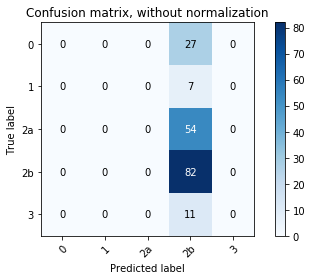

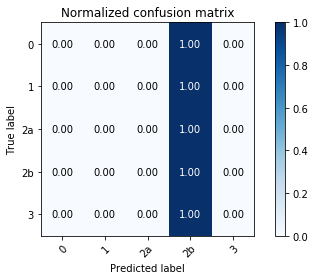

<Figure size 432x288 with 0 Axes>

In [0]:
# from the sklearn library example
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
# Plot non-normalized confusion matrix
plot_confusion_matrix(ys, preds, classes=['0', '1', '2a', '2b', '3'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(ys, preds, classes=['0', '1', '2a', '2b', '3'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()
plt.savefig('confusion_simple.png')

Why is it classifying everything into one class....

In [0]:
count = 0
for i in ys:
  if i == '2b':
    count+=1
print(count/(len(ys)))

0.4530386740331492


Ok so it actually is just classifying into 2b only

#### Inception

In [0]:
def train_inception_gen_model(model, batch_size, epochs, x, y, xt, yt, rot=20, width=0.2, height=0.2):
  # force images to have three channels
  xnew = np.zeros((x.shape[0], 512, 512, 3))
  for i in range(0, x.shape[0]):
      xnew[i, :, :, 0] = x[i]
      xnew[i, :, :, 1] = x[i]
      xnew[i, :, :, 2] = x[i]

  xtnew = np.zeros((xt.shape[0], 512, 512, 3))
  for i in range(0, xt.shape[0]):
      xtnew[i, :, :, 0] = xt[i]
      xtnew[i, :, :, 1] = xt[i]
      xtnew[i, :, :, 2] = xt[i]
      
  train_generator, validation_generator = create_generators(xnew, y, xtnew, yt, batch_size, rot, width, height)

  rmsprop = keras.optimizers.RMSprop(lr=0.005)
  
  model.compile(
    loss=categorical_crossentropy,
    optimizer=rmsprop,
    metrics=['accuracy'])

  model.fit_generator(
        train_generator,
        epochs=epochs,
        verbose=1,
        steps_per_epoch = np.ceil(x.shape[0]/batch_size),
        validation_steps = np.ceil(xt.shape[0]/batch_size),
        validation_data=validation_generator)
  score = model.evaluate(xtnew, yt, verbose=0)
  return score, model, xtnew

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

cv = StratifiedKFold(5)

model = create_inception_model()

x = clean_data.drop('y', axis=1)
y = [str(val) for val in clean_data['y'].values]
x = x.values
x = np.array([arr[0] for arr in x])

acc = 0
preds = np.array([])
ys = np.array([])
target_names = ['0', '1', '2a', '2b', '3']

j = 1
for train, test in cv.split(x, y):
    x_train = x[train]
    y_train = [y[i] for i in train]
    x_test = x[test]
    y_test = [y[i] for i in test]
    
    y_train_hot = pd.get_dummies(y_train)
    y_test_hot = pd.get_dummies(y_test)
    
    batch_size = 20
    score, model, xtnew = train_inception_gen_model(model, batch_size, 10, x_train, y_train_hot, x_test, y_test_hot, 90, 0.5, 0.5)
    
    Y_pred = model.predict(xtnew, batch_size, len(y_test) // batch_size + 1)
    y_pred = np.argmax(Y_pred, axis=1)
    preds = np.append(preds, [target_names[ind] for ind in y_pred.astype(int)])
    ys = np.append(ys, y_test)
    
    print ('Fold #', j, 'Accuracy', score[1])
    acc+=score[1]
    j+=1

Epoch 1/10
8/8 [==============================] - 45s 6s/step - loss: 4.1737 - acc: 0.3606 - val_loss: 2.1789 - val_acc: 0.4359
Epoch 2/10
8/8 [==============================] - 7s 895ms/step - loss: 2.6635 - acc: 0.4120 - val_loss: 1.4491 - val_acc: 0.4359
Epoch 3/10
8/8 [==============================] - 7s 893ms/step - loss: 2.6238 - acc: 0.3676 - val_loss: 2.4222 - val_acc: 0.2821
Epoch 4/10
8/8 [==============================] - 7s 891ms/step - loss: 2.9795 - acc: 0.4176 - val_loss: 11.5720 - val_acc: 0.2821
Epoch 5/10
8/8 [==============================] - 8s 968ms/step - loss: 3.0503 - acc: 0.3106 - val_loss: 11.5720 - val_acc: 0.2821
Epoch 6/10
8/8 [==============================] - 9s 1s/step - loss: 2.9331 - acc: 0.4056 - val_loss: 9.2998 - val_acc: 0.2821
Epoch 7/10
8/8 [==============================] - 9s 1s/step - loss: 2.8168 - acc: 0.3606 - val_loss: 9.0923 - val_acc: 0.4359
Epoch 8/10
8/8 [==============================] - 10s 1s/step - loss: 2.6782 - acc: 0.4620 - val

In [0]:
print('Mean Accuracy', acc/(j-1))
confusion = confusion_matrix(ys, preds)
print(confusion)

Mean Accuracy 0.4650565329048503
[[ 0  0  4 23  0]
 [ 0  0  1  6  0]
 [ 0  0  7 47  0]
 [ 0  0  5 77  0]
 [ 0  0  1 10  0]]


Confusion matrix, without normalization
[[ 0  0  4 23  0]
 [ 0  0  1  6  0]
 [ 0  0  7 47  0]
 [ 0  0  5 77  0]
 [ 0  0  1 10  0]]
Normalized confusion matrix
[[0.   0.   0.15 0.85 0.  ]
 [0.   0.   0.14 0.86 0.  ]
 [0.   0.   0.13 0.87 0.  ]
 [0.   0.   0.06 0.94 0.  ]
 [0.   0.   0.09 0.91 0.  ]]


<Figure size 432x288 with 0 Axes>

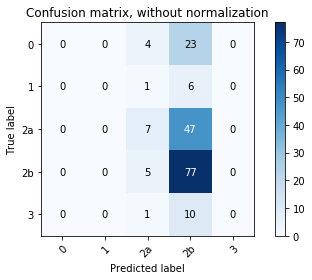

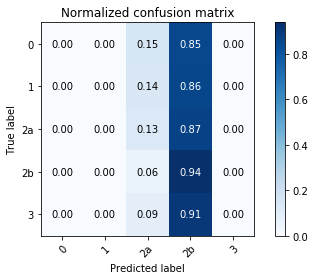

In [0]:
# from the sklearn library example
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
fig = plt.figure()
# Plot non-normalized confusion matrix
plot_confusion_matrix(ys, preds, classes=['0', '1', '2a', '2b', '3'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(ys, preds, classes=['0', '1', '2a', '2b', '3'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()
fig.savefig('confusion_inception2.png')

Better than just classifying into one class I guess, but fewer were classified into the correct class...

## Try Classification for all except separating 2b and 2a, and then try run another classifier to separate 2a and 2b --- Failed

In [0]:
conditions = [
    (clean_data['y'] == '2b'),
    (clean_data['y'] == '2a')]
choices = ['2b', '2a']
clean_data['ynew'] = np.select(conditions, choices, default='not2a2b')

In [0]:
conditions = [
    (clean_data['y'] == 0),
    (clean_data['y'] == 1),
    (clean_data['y'] == 3)]
choices = ['0', '1', '3']
clean_data['ynew2'] = np.select(conditions, choices, default='is2a2b')

In [0]:
def create_simple_model1():
  model = Sequential([
      l.Conv2D(32, 5, padding='same', activation='relu', input_shape=(512,512,1)),
      l.MaxPooling2D((2, 2), (2, 2), padding='same'),
      l.BatchNormalization(),
      l.Conv2D(64, 5, padding='same', activation='relu'),
      l.MaxPooling2D((2, 2), (2, 2), padding='same'),
      l.Conv2D(64, 5, padding='same', activation='relu'),
      l.MaxPooling2D((2, 2), (2, 2), padding='same'),
      l.Conv2D(64, 5, padding='same', activation='relu'),
      l.MaxPooling2D((2, 2), (2, 2), padding='same'),
      l.Conv2D(64, 5, padding='same', activation='relu'),
      l.MaxPooling2D((2, 2), (2, 2), padding='same'),
      l.Conv2D(64, 5, padding='same', activation='relu'),
      l.MaxPooling2D((2, 2), (2, 2), padding='same'),
      l.Flatten(),
      l.Dense(1024, activation='relu'),
      l.Dropout(0.4),
      l.Dense(3,activation='softmax')
  ])


  return model

def create_simple_model2():
  model = Sequential([
      l.Conv2D(32, 5, padding='same', activation='relu', input_shape=(512,512,1)),
      l.MaxPooling2D((2, 2), (2, 2), padding='same'),
      l.BatchNormalization(),
      l.Conv2D(64, 5, padding='same', activation='relu'),
      l.MaxPooling2D((2, 2), (2, 2), padding='same'),
      l.Conv2D(64, 5, padding='same', activation='relu'),
      l.MaxPooling2D((2, 2), (2, 2), padding='same'),
      l.Conv2D(64, 5, padding='same', activation='relu'),
      l.MaxPooling2D((2, 2), (2, 2), padding='same'),
      l.Conv2D(64, 5, padding='same', activation='relu'),
      l.MaxPooling2D((2, 2), (2, 2), padding='same'),
      l.Conv2D(64, 5, padding='same', activation='relu'),
      l.MaxPooling2D((2, 2), (2, 2), padding='same'),
      l.Flatten(),
      l.Dense(1024, activation='relu'),
      l.Dropout(0.4),
      l.Dense(4,activation='softmax')
  ])


  return model

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

cv = StratifiedKFold(5)

model1 = create_simple_model1()
model2 = create_simple_model2()

x = clean_data.drop('y', axis=1)
x = clean_data.drop('ynew', axis=1)
x = x.values
x = np.array([arr[0] for arr in x])

y1 = [str(i) for i in clean_data['ynew'].values]
y2 = [str(i) for i in clean_data['ynew2'].values]
y = [str(i) for i in clean_data['y'].values]

acc1 = 0
acc2 = 0
preds = np.array([])
ys = np.array([])
y2s = np.array([])
y2_preds = np.array([])
target_names1 = ['2a', '2b', 'not2a2b']
target_names2 = ['0', '1', '3', 'is2a2b']

j = 1
for train, test in cv.split(x, y):
    x_train = x[train]
    y_train1 = [y1[i] for i in train]
    y_train2 = [y2[i] for i in train]
    x_test = x[test]
    y_test1 = [y1[i] for i in test]
    y_test2 = [y2[i] for i in test]
    y_test = [y[i] for i in test]
    
    y_train_hot1 = pd.get_dummies(y_train1)
    y_test_hot1 = pd.get_dummies(y_test1)
    
    y_train_hot2 = pd.get_dummies(y_train2)
    y_test_hot2 = pd.get_dummies(y_test2)
    
    batch_size = 20
    score1, model1 = train_simple_gen_model(model1, batch_size, 10, x_train, y_train_hot1, x_test, y_test_hot1)
    score2, model2 = train_simple_gen_model(model2, batch_size, 10, x_train, y_train_hot2, x_test, y_test_hot2)
    
    Y_pred1 = model1.predict(x_test.reshape(x_test.shape[0], img_rows, img_cols, 1), batch_size, len(y_test) // batch_size + 1)
    y_pred_ind1 = np.argmax(Y_pred1, axis=1)
    y_pred1 = [target_names1[ind] for ind in y_pred_ind1.astype(int)]
    
    Y_pred2 = model2.predict(x_test.reshape(x_test.shape[0], img_rows, img_cols, 1), batch_size, len(y_test) // batch_size + 1)
    y_pred_ind2 = np.argmax(Y_pred2, axis=1)
    y_pred2 = [target_names2[ind] for ind in y_pred_ind2.astype(int)]
    
    y2_preds = np.append(y2_preds, y_pred2)
    y2s = np.append(y2s, y_test2)
    
    for i in range(len(y_pred1)):
      if y_pred2[i] != 'is2a2b':
        continue
      elif y_pred1[i] == 'not2a2b':
          y_pred2[i] = '2a'
      else:
        y_pred2[i] = y_pred1[i]
    
    
    preds = np.append(preds, y_pred2)
    ys = np.append(ys, y_test)
    
    
    
    print ('Fold #', j, 'Accuracy 1st', score1[1])
    print ('Fold #', j, 'Accuracy 2nd', score2[1])
    acc1+=score1[1]
    acc2+=score2[1]
    j+=1

Epoch 1/10
8/8 [==============================] - 13s 2s/step - loss: 1.1082 - acc: 0.4113 - val_loss: 1.0839 - val_acc: 0.4359
Epoch 2/10
8/8 [==============================] - 2s 244ms/step - loss: 1.0861 - acc: 0.4620 - val_loss: 1.0803 - val_acc: 0.4359
Epoch 3/10
8/8 [==============================] - 2s 240ms/step - loss: 1.0847 - acc: 0.4120 - val_loss: 1.0803 - val_acc: 0.4359
Epoch 4/10
8/8 [==============================] - 2s 239ms/step - loss: 1.0675 - acc: 0.4620 - val_loss: 1.0803 - val_acc: 0.4359
Epoch 5/10
8/8 [==============================] - 3s 318ms/step - loss: 1.0887 - acc: 0.4120 - val_loss: 1.0839 - val_acc: 0.4359
Epoch 6/10
8/8 [==============================] - 3s 333ms/step - loss: 1.0965 - acc: 0.4120 - val_loss: 1.0848 - val_acc: 0.4359
Epoch 7/10
8/8 [==============================] - 3s 334ms/step - loss: 1.0671 - acc: 0.5120 - val_loss: 1.0841 - val_acc: 0.4359
Epoch 8/10
8/8 [==============================] - 3s 334ms/step - loss: 1.0906 - acc: 0.4120

In [0]:
print('Mean Accuracy 1', acc1/(j-1))
print('Mean Accuracy 2', acc2/(j-1))
from sklearn.metrics import accuracy_score
print('Total Accuracy', accuracy_score(ys, preds))

Mean Accuracy 1 0.4536279613059799
Mean Accuracy 2 0.75247077002499
Total Accuracy 0.4530386740331492


In [0]:
# from the sklearn library example
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
from matplotlib import pyplot as plt
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[ 0  0  0 27  0]
 [ 0  0  0  7  0]
 [ 0  0  0 54  0]
 [ 0  0  0 82  0]
 [ 0  0  0 11  0]]
Normalized confusion matrix
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


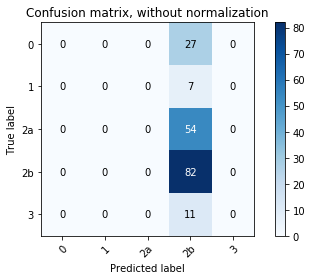

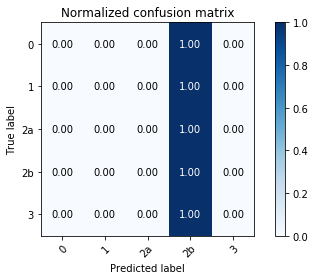

In [0]:
# from the sklearn library example
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
# Plot non-normalized confusion matrix
plot_confusion_matrix(ys, preds, classes=['0', '1', '2a', '2b', '3'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(ys, preds, classes=['0', '1', '2a', '2b', '3'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[  0   0   0  27]
 [  0   0   0   7]
 [  0   0   0  11]
 [  0   0   0 136]]
Normalized confusion matrix
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


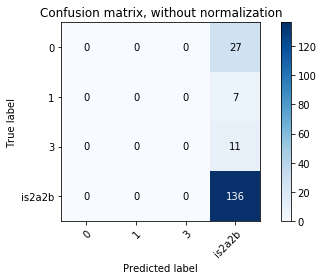

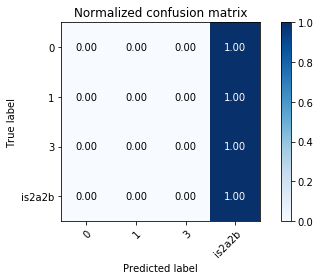

In [0]:
# from the sklearn library example
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
# Plot non-normalized confusion matrix
plot_confusion_matrix(y2s, y2_preds, classes=['0', '1', '3', 'is2a2b'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y2s, y2_preds, classes=['0', '1', '3', 'is2a2b'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:
count = 0
for i in clean_data['y'].values:
  if i == 0 or i == 1 or i == 3:
    count+=1
print(count)

45


So only 45 data points are values other than 2a and 2b, thus about 136 are 2a and 2b. The data is taken over by 2a and 2b data points